Homework 6 \\
Author: Warren Shepard \\
Collaboration: Sri Korandla, Tushar Aggarwal \\

# Neural networks and computer vision

### Objective
In this week's project, you will learn to train, validate, and test a neural network. You will explore how inputs change through feature extraction in convolutional neural networks (CNNs), and you will interpret the trained filters by the network.

#### Dataset

You will use the MNIST dataset, a standard dataset of handwritten digits, which is widely used for training and testing image processing systems.

#### Instructions

The code example below demonstrates how to define, train, validate, and test a CNN. The training and test accuracy after each completed epoch are shown after a completed

**1. Explore a working example**
1. Open `example.ipynb` and read the code.
2. Consult the pytorch documentation to learn what the arguments of the various employed pytorch functions mean.
3. Run the code.
4. Replace SGD with Adam in the training process. Then run the code again.
5. Save the output figures that show training and validation accuracy as a function of the number of epochs in your file system.

**2. Build a network**
Create your own working example. (You are allowed to copy any amount of code from `example.ipynb`.) Your CNN should be different from the CNN in the working example in the following ways:
1. The new CNN should have three convolutional layers instead of two. The first layer creates 32 channels. The second layer creates 64 channels, and the third layer creates 128 channels.
2. The pooling layer after the third layer should not employ any padding.
3. The last hidden layer should have 512 neurons.
4. For all layers except the output layer, the activation function should be a ReLU (use `torch.nn.ReLU`).

**3. Train and evaluate a neural network**
1. Train the neural network that you have constructed in the previous step. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's training time?
2. Test the neural network. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's validation accuracy?
3. Identify the number $k$ of training epochs that gives you a good tradeoff between training time and validation accuracy.
4. Run your code again using $k$ epochs during training. Time the training (e.g. using the python library `time`).

**4. Model validation and model selection**
1. Use the validation set approach to identify the best number $c$ of channels in the first convolutional layer (consider $c\in\{2,15\}$).
2. Update your neural network architecture so that the first convolutional layer has $c$ channels.

**5. Visualizing feature extraction**
1. Use the function `plot_mapped_features` to view an input image and the corresponding first channel of the hidden state for each feature-extraction layer (i.e., each convolution layer and each pooling layer).
2. Update the function so that it shows all channels instead of just one.
3. Comment on where you observe differences between the channels within a layer.

**6. Visualizing and interpreting filters**
1. Use the function `plot_filters` to view the trained filters of the first convolutional layer.
2. Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

**7. Comparison to logistic regression**
1. Construct and run a pipeline for multiclass logistic regression of the MNIST dataset using sklearn.
2. Comment on how the training time and test accuracy of logistic regression compare to the CNN.
3. Now run multiclass logistic regression on the MNIST data set using one of the hidden states of the CNN (i.e., $\vec{x}^{(2)}$, $\vec{x}^{(3)}$, ..., $\vec{x}^{(7)}$) as inputs. Which set of inputs yields the best classification results?

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

In [2]:
# Load and preprocess the MNIST dataset

# Define an array transformation that transforms the images to tensor format
# and normalizes the pixel values to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
    download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
    download=True, transform=transform)

# Split the training dataset into a training set and a validation set
train_set, val_set = random_split(train_dataset, [50000, 10000])

# Create data loaders for the training, validation, and test sets
# A DataLoader in PyTorch is an object that simplifies and automates
# batching, shuffling, and loading data for model training and evaluation.
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4201562.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 53451.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 236065.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5908972.94it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**2. Build a network**
Create your own working example. (You are allowed to copy any amount of code from `example.ipynb`.) Your CNN should be different from the CNN in the working example in the following ways:
1. The new CNN should have three convolutional layers instead of two. The first layer creates 32 channels. The second layer creates 64 channels, and the third layer creates 128 channels.
2. The pooling layer after the third layer should not employ any padding.
3. The last hidden layer should have 512 neurons.
4. For all layers except the output layer, the activation function should be a ReLU (use `torch.nn.ReLU`).

In [ ]:
# Define CNN architecture

class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST images.

    The network consists of a feature extraction architecture and a
    classification architecture. The feature-extraction architecture includes
    two convolutional layers. Each of the convolutional layers is followed by
    a sigmoid activation and a max pooling layer. The classification
    architecture includes two fully connected layers for classification.

    Attributes:
    conv1 : torch.nn.Conv2d
        The first convolutional layer
    conv2 : torch.nn.Conv2d
        The second convolutional layer
    conv3 : torch.nn.Conv2d
        The third convolutional layer
    activation : torch.nn activation function
        Activation function used for input and hidden layers
    pool : torch.nn.MaxPool2d
        The pooling layer
    fc1 : torch.nn.Linear
        The first fully connected layer
    fc2 : torch.nn.Linear
        The second fully connected layer

    Methods:
    __init__(self):
        This function creates an instance of this class.
    forward(self, x):
        Performs a forward pass for an input x.
    """

    def __init__(self):
        """
        Initialize the CNN model by defining its layers.
        """
        # Create an instance of the parent class `nn.Module`
        super(CNN, self).__init__()

        # `self.name = object` creates an attribute with the name `name` for
        # our the newly created instance of our class, and it assigns that
        # attribute the value `object`. Example: For your first homework, you
        # could have create a class `TicTacToe`. Adding the line
        # `self.is_game_over = False` to the instance-initialization function
        # of that class would ensure that everytime a new game of TicTacToe is
        # initialized, it would have an attribute `is_game_over` and initially
        # the value of that attribute would be `False`.
        # Here, we use the class-attribute syntax to create layers for our CNN.

        # Define the first convolutional layer. It uses a 32 filters of size
        # 3-by-3 to turn a 1-channel image into an 32-channel image.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        # The MNIST images are grayscale images. Therefore, the input data for
        # out CNN has only one channel. Color images typically come with three
        # channels: a red channel, a green channel, and a blue channel.
        # Throughout the feature extraction, the number of channels typically
        # changes quite drastically. The channels of the transformed features
        # typically do not correspond to colors anymore. Instead, different
        # channels of the transformed image contain different information about
        # the original image. For example, a channel created by applying an
        # edge-detection filter would have information about the locations of
        # sharp edges. A channel created by applying a blur filter would have
        # information about the coarse-grained distribution of light and dark
        # patches.

        # Define the second convolutional layer. It uses 64 filters of size
        # 3-by-3 to turn a 32-channel image into an 64-channel image.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # ADDED THIS
        # Define the third convolutional layer. It uses 128 filters of size
        # 3-by-3 to turn a 64-channel image into an 128-channel image.
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the activation function CHANGED TO nn.ReLU
        self.activation = nn.ReLU()
        self.activation_no_ReLU = nn.Sigmoid()

        # Define a pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        # Define a pooling layer without padding
        self.pool_no_padding = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define a fully connected layer hidden with 512 nodes
        # Inputs are num_channels in previous layer x image height x image width
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Define the output layer with 10 nodes
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        """
        Define the forward pass of the CNN.

        Parameters:
        x : torch.Tensor
            The input tensor containing the image batch.

        Returns:
        torch.Tensor
            The output tensor containing the class scores for each image.
        """
        # Pass the input through the first convolutional layer, then apply activation
        x = self.activation(self.conv1(x))
        # Pass the input through the first pooling layer
        x = self.pool(x)
        # Pass the input through the second convolutional layer, then apply activation
        x = self.activation(self.conv2(x))
        # Pass the input through the second pooling layer
        x = self.pool(x)
        # Pass the input through the third convolutional layer, then apply activation
        x = self.activation(self.conv3(x))
        # Pass the input through the third pooling layer, WITHOUT PADDING
        x = self.pool_no_padding(x)
        # Change the shape of x into a 1d array
        x = x.view(-1, 128 * 4 * 4)
        # Pass the input through the full connected hidden layer, then apply activation
        x = self.activation_no_ReLU(self.fc1(x))
        # Pass the input through the last layer
        x = self.fc2(x)
        return x

**3. Train and evaluate a neural network**
1. Train the neural network that you have constructed in the previous step. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's training time?
2. Test the neural network. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's validation accuracy?
3. Identify the number $k$ of training epochs that gives you a good tradeoff between training time and validation accuracy.
4. Run your code again using $k$ epochs during training. Time the training (e.g. using the python library `time`).

In [3]:
# Define training pipeline including validation after each epoch

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train the CNN model.

    Parameters:
    model : torch.nn.Module
        The CNN model to be trained.
    train_loader : torch.utils.data.DataLoader
        The data loader for the training set.
    val_loader : torch.utils.data.DataLoader
        The data loader for the validation set.
    criterion : torch.nn.modules.loss._Loss
        The loss function to be used.
    optimizer : torch.optim.Optimizer
        The optimizer to be used.
    epochs : int
        The number of epochs for training.

    Returns:
    tuple
        A tuple containing lists of training loss, validation loss, training accuracy, and validation accuracy.
    """
    # Initialize lists to store training and validation loss
    train_loss, val_loss = [], []
    # Initialize lists to store training and validation and accuracy
    train_acc, val_acc = [], []

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        # Initialize the running loss for the epoch
        running_loss = 0.0
        # Initialize counters for correct predictions and total samples
        correct, total = 0, 0

        # Learning algorithm is SGD with minibatch. Iterating over the dataload
        # returns images and labels in batches.

        # Iterate over batches of training data
        for images, labels in train_loader:
            # Zero the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            # Perform a forward pass through the model to get predictions
            outputs = model(images)
            # Compute the loss between predictions and true labels
            loss = criterion(outputs, labels)
            # Perform a backward pass to compute gradients via backpropagation
            loss.backward()
            # Update model parameters based on the computed gradients
            optimizer.step()

            # Add up the loss
            running_loss += loss.item()
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            # Update the total number of samples
            total += labels.size(0)
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()

        # Compute and store the average training loss for the epoch
        train_loss.append(running_loss / len(train_loader))
        # Compute and store the training accuracy for the epoch
        train_acc.append(100 * correct / total)

        # Set the model to evaluation mode
        model.eval()
        # Initialize the running loss for validation
        val_running_loss = 0.0
        #  Initialize counters for correct predictions and total samples in validation
        val_correct, val_total = 0, 0

        # Disable gradient calculation for validation to save memory and computation
        with torch.no_grad():
            # Iterate over batches of validation data
            for images, labels in val_loader:
                # Perform a forward pass through the model to get predictions
                outputs = model(images)
                # Compute the loss between predictions and true labels
                loss = criterion(outputs, labels)
                # Add up the loss
                val_running_loss += loss.item()
                # Get the predicted class with the highest score
                _, predicted = torch.max(outputs.data, 1)
                # Update the total number of samples in validation
                val_total += labels.size(0)
                # Update the number of correct predictions in validation
                val_correct += (predicted == labels).sum().item()

        # Compute and store the average validation loss for the epoch
        val_loss.append(val_running_loss / len(val_loader))
        # Compute and store the validation accuracy for the epoch
        val_acc.append(100 * val_correct / val_total)

        # Print the results for the current epoch, including training and validation loss and accuracy
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
              f'Train Acc: {100 * correct / total:.2f}%, Val Acc: {100 * val_correct / val_total:.2f}%')

    # Return the lists of training and validation loss and accuracy
    return train_loss, val_loss, train_acc, val_acc

In [ ]:
# Build and train a model

# Create model
model = CNN()

# Set loss function
criterion = nn.CrossEntropyLoss()

# Set training algorithm
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/10], Train Loss: 0.2776, Validation Loss: 0.0888, Train Acc: 91.60%, Val Acc: 97.33%
Epoch [2/10], Train Loss: 0.0548, Validation Loss: 0.0490, Train Acc: 98.33%, Val Acc: 98.57%
Epoch [3/10], Train Loss: 0.0341, Validation Loss: 0.0360, Train Acc: 99.01%, Val Acc: 98.89%
Epoch [4/10], Train Loss: 0.0254, Validation Loss: 0.0388, Train Acc: 99.22%, Val Acc: 98.85%
Epoch [5/10], Train Loss: 0.0203, Validation Loss: 0.0294, Train Acc: 99.40%, Val Acc: 99.03%
Epoch [6/10], Train Loss: 0.0148, Validation Loss: 0.0302, Train Acc: 99.56%, Val Acc: 99.09%
Epoch [7/10], Train Loss: 0.0102, Validation Loss: 0.0281, Train Acc: 99.70%, Val Acc: 99.16%
Epoch [8/10], Train Loss: 0.0088, Validation Loss: 0.0302, Train Acc: 99.75%, Val Acc: 99.03%
Epoch [9/10], Train Loss: 0.0078, Validation Loss: 0.0274, Train Acc: 99.76%, Val Acc: 99.07%
Epoch [10/10], Train Loss: 0.0076, Validation Loss: 0.0288, Train Acc: 99.77%, Val Acc: 99.14%


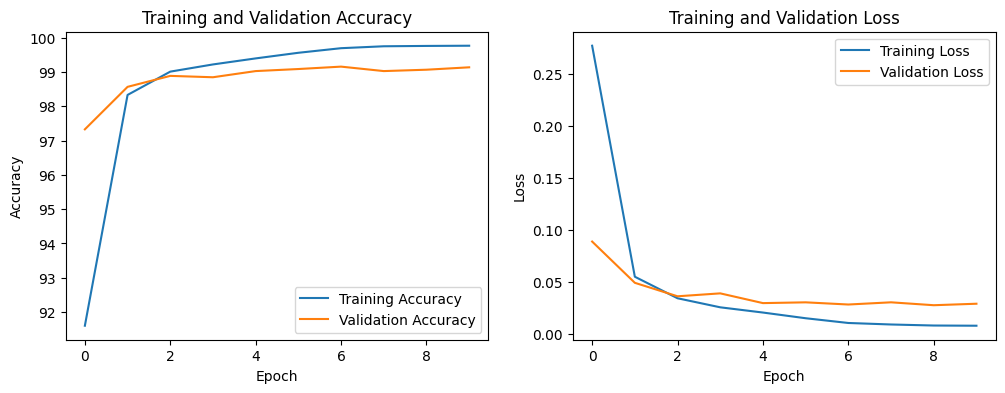

In [ ]:
# Plot training & validation accuracy/loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()

Clearly, 4 epocs is sufficent to both achive maximal accuracy (99.13%). Alernatively, training with two or three epocs could be sufficent. At the very least, training with two or three epocs will be better than training the original model in `example.ipynb` with ten epocs.

In [ ]:
# Build and train a model

# Create model
four_epochs_model = CNN()

# Set loss function
new_criterion = nn.CrossEntropyLoss()

# Set training algorithm
new_optimizer = optim.Adam(four_epochs_model.parameters(), lr=0.001)

start = time.time()

# Train model
four_epochs_train_loss, four_epochs_val_loss, four_epochs_train_acc, four_epochs_val_acc = train_model(four_epochs_model, train_loader, val_loader, new_criterion, new_optimizer, epochs=4)

stop = time.time()
print(f"Training time: {stop - start} seconds")

Epoch [1/4], Train Loss: 0.2756, Validation Loss: 0.0767, Train Acc: 91.55%, Val Acc: 97.45%
Epoch [2/4], Train Loss: 0.0545, Validation Loss: 0.0482, Train Acc: 98.41%, Val Acc: 98.50%
Epoch [3/4], Train Loss: 0.0364, Validation Loss: 0.0484, Train Acc: 98.90%, Val Acc: 98.49%
Epoch [4/4], Train Loss: 0.0247, Validation Loss: 0.0457, Train Acc: 99.22%, Val Acc: 98.54%
Training time: 521.5273542404175 seconds


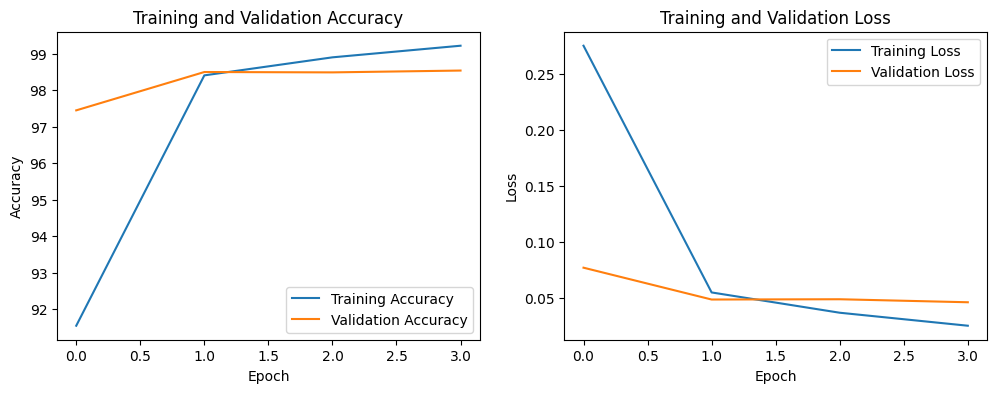

In [ ]:
# Plot training & validation accuracy/loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(four_epochs_train_acc, label='Training Accuracy')
plt.plot(four_epochs_val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(four_epochs_train_loss, label='Training Loss')
plt.plot(four_epochs_val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()

**4. Model validation and model selection**
1. Use the validation set approach to identify the best number $c$ of channels in the first convolutional layer (consider $c\in\{2,15\}$).
2. Update your neural network architecture so that the first convolutional layer has $c$ channels.

In [4]:
# Define CNN architecture

class CNN_custom_c(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST images.

    The network consists of a feature extraction architecture and a
    classification architecture. The feature-extraction architecture includes
    two convolutional layers. Each of the convolutional layers is followed by
    a sigmoid activation and a max pooling layer. The classification
    architecture includes two fully connected layers for classification.

    Attributes:
    conv1 : torch.nn.Conv2d
        The first convolutional layer
    conv2 : torch.nn.Conv2d
        The second convolutional layer
    conv3 : torch.nn.Conv2d
        The third convolutional layer
    activation : torch.nn activation function
        Activation function used for input and hidden layers
    pool : torch.nn.MaxPool2d
        The pooling layer
    fc1 : torch.nn.Linear
        The first fully connected layer
    fc2 : torch.nn.Linear
        The second fully connected layer

    Methods:
    __init__(self):
        This function creates an instance of this class.
    forward(self, x):
        Performs a forward pass for an input x.
    """

    def __init__(self, c):
        """
        Initialize the CNN model by defining its layers.
        """
        # Create an instance of the parent class `nn.Module`
        super(CNN_custom_c, self).__init__()

        # CHANGE HERE
        # Define the first convolutional layer. It uses c filters of size
        # 3-by-3 to turn a 1-channel image into an c-channel image.
        self.conv1 = nn.Conv2d(1, c, kernel_size=3, padding=1)

        # CHANGE HERE
        # Define the second convolutional layer. It uses 64 filters of size
        # 3-by-3 to turn a c-channel image into an 64-channel image.
        self.conv2 = nn.Conv2d(c, 64, kernel_size=3, padding=1)

        # ADDED THIS
        # Define the third convolutional layer. It uses 128 filters of size
        # 3-by-3 to turn a 64-channel image into an 128-channel image.
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the activation function CHANGED TO nn.ReLU
        self.activation = nn.ReLU()
        self.activation_no_ReLU = nn.Sigmoid()

        # Define a pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        # Define a pooling layer without padding
        self.pool_no_padding = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define a fully connected layer hidden with 512 nodes
        # Inputs are num_channels in previous layer x image height x image width
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Define the output layer with 10 nodes
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        """
        Define the forward pass of the CNN.

        Parameters:
        x : torch.Tensor
            The input tensor containing the image batch.

        Returns:
        torch.Tensor
            The output tensor containing the class scores for each image.
        """
        # Pass the input through the first convolutional layer, then apply activation
        x = self.activation(self.conv1(x))
        # Pass the input through the first pooling layer
        x = self.pool(x)
        # Pass the input through the second convolutional layer, then apply activation
        x = self.activation(self.conv2(x))
        # Pass the input through the second pooling layer
        x = self.pool(x)
        # Pass the input through the third convolutional layer, then apply activation
        x = self.activation(self.conv3(x))
        # Pass the input through the third pooling layer, WITHOUT PADDING
        x = self.pool_no_padding(x)
        # Change the shape of x into a 1d array
        x = x.view(-1, 128 * 4 * 4)
        # Pass the input through the full connected hidden layer, then apply activation
        x = self.activation_no_ReLU(self.fc1(x))
        # Pass the input through the last layer
        x = self.fc2(x)
        return x

In [ ]:
num_epochs = 4
results = []

for c in range(2, 16):
  # Build and train a model

  # Create model
  model = CNN_custom_c(c)

  # Set loss function
  criterion = nn.CrossEntropyLoss()

  # Set training algorithm
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Train model
  train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = num_epochs)

  results.append((c, train_acc, val_acc, train_loss, val_loss))

Epoch [1/4], Train Loss: 0.3820, Validation Loss: 0.0939, Train Acc: 88.42%, Val Acc: 97.07%
Epoch [2/4], Train Loss: 0.0788, Validation Loss: 0.0765, Train Acc: 97.59%, Val Acc: 97.44%
Epoch [3/4], Train Loss: 0.0552, Validation Loss: 0.0509, Train Acc: 98.34%, Val Acc: 98.36%
Epoch [4/4], Train Loss: 0.0394, Validation Loss: 0.0434, Train Acc: 98.78%, Val Acc: 98.57%
Epoch [1/4], Train Loss: 0.4526, Validation Loss: 0.1209, Train Acc: 85.74%, Val Acc: 96.30%
Epoch [2/4], Train Loss: 0.0904, Validation Loss: 0.0805, Train Acc: 97.24%, Val Acc: 97.47%
Epoch [3/4], Train Loss: 0.0629, Validation Loss: 0.0643, Train Acc: 97.99%, Val Acc: 97.92%
Epoch [4/4], Train Loss: 0.0486, Validation Loss: 0.0537, Train Acc: 98.48%, Val Acc: 98.28%
Epoch [1/4], Train Loss: 0.4506, Validation Loss: 0.1186, Train Acc: 85.66%, Val Acc: 96.34%
Epoch [2/4], Train Loss: 0.0841, Validation Loss: 0.0637, Train Acc: 97.43%, Val Acc: 98.07%
Epoch [3/4], Train Loss: 0.0565, Validation Loss: 0.0531, Train Acc: 9

In [ ]:
results_parsed = []

# Iterate over the results list to extract the last item of each list
for result in results:
    c = result[0]
    train_acc = result[1][-1]
    val_acc = result[2][-1]
    train_loss = result[3][-1]
    val_loss = result[4][-1]
    results_parsed.append((c, train_acc, val_acc, train_loss, val_loss))

# Convert the parsed results into a pandas DataFrame
results_parsed_df = pd.DataFrame(results_parsed, columns=['c', 'train_acc', 'val_acc', 'train_loss', 'val_loss'])

# Display the DataFrame
results_parsed_df

,c,train_acc,val_acc,train_loss,val_loss
0,2,98.784,98.57,0.039373,0.043412
1,3,98.476,98.28,0.048568,0.053696
2,4,98.748,98.34,0.040680,0.057570
3,5,98.998,98.72,0.032167,0.041962
4,6,98.974,98.71,0.032804,0.042687
5,7,99.012,98.92,0.032338,0.036546
6,8,99.130,98.92,0.027388,0.035447
7,9,99.126,98.41,0.028268,0.049863
8,10,99.180,98.82,0.028147,0.039819
9,11,99.112,98.86,0.028686,0.033699


Clearly, c=14 had the best validation accuracy. Hence, we will train with c=14. However, the varience is very low, so it does not matter too much which value of c we choose, but we will still use c=14 in order to get the best of the best accuracy

In [5]:
# Create model
optimized_model = CNN_custom_c(14)

# Set loss function
criterion = nn.CrossEntropyLoss()

# Set training algorithm
optimizer = optim.Adam(optimized_model.parameters(), lr=0.001)

start = time.time()

# Train model
train_loss, val_loss, train_acc, val_acc = train_model(optimized_model, train_loader, val_loader, criterion, optimizer, epochs = 4)

stop = time.time()
print(f"Training time: {stop - start} seconds")

Epoch [1/4], Train Loss: 0.2592, Validation Loss: 0.0589, Train Acc: 92.22%, Val Acc: 98.19%
Epoch [2/4], Train Loss: 0.0494, Validation Loss: 0.0441, Train Acc: 98.43%, Val Acc: 98.75%
Epoch [3/4], Train Loss: 0.0321, Validation Loss: 0.0387, Train Acc: 99.01%, Val Acc: 98.87%
Epoch [4/4], Train Loss: 0.0227, Validation Loss: 0.0319, Train Acc: 99.31%, Val Acc: 99.06%
Training time: 98.64235424995422 seconds


**5. Visualizing feature extraction**
1. Use the function `plot_mapped_features` to view an input image and the corresponding first channel of the hidden state for each feature-extraction layer (i.e., each convolution layer and each pooling layer).
2. Update the function so that it shows all channels instead of just one.
3. Comment on where you observe differences between the channels within a layer.


In [ ]:
# Function to visualize the feature maps produced by different layers for a given image
def plot_mapped_features(model, image, layers):
    '''Example usage:

    >>> examples = iter(test_loader)
    >>> example_data, example_labels = next(examples) # get one batch from test set
    >>> example_image = example_data[0]
    >>> layers = [model.conv1, model.pool, model.conv2, model.pool]
    >>> plot_mapped_features(model, example_image, layers)

    '''
    # Add a batch dimension to the image tensor (from (channels, height, width) to (1, channels, height, width))
    x = image.unsqueeze(0)
    # Create a subplot with 1 row and len(layers) columns
    fig, axes = plt.subplots(1, len(layers))
    # Iterate over the specified layers
    for i, layer in enumerate(layers):

        # Pass the image through the current layer
        x = layer(x)

        # Detach the feature map from the computation graph and move it to CPU, then convert it to a NumPy array
        # Visualize the first channel of the feature map
        axes[i].imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')

        # Turn off the axis for a cleaner look
        axes[i].axis('off')

    # Display the feature maps
    plt.show()

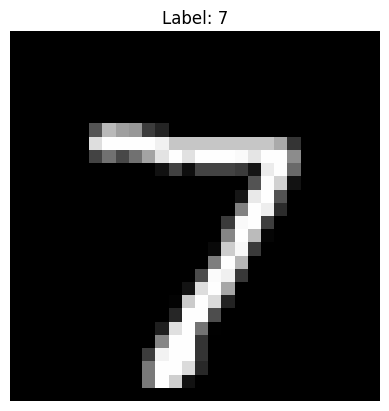

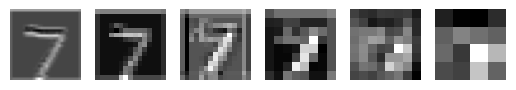

In [ ]:
# Retrieve a batch of data from the test_loader
examples = iter(test_loader)
example_data, example_labels = next(examples)

# Extract an image and its corresponding label from the batch
example_image = example_data[0]
example_label = example_labels[0]

# Visualize the image
plt.imshow(example_image.squeeze(), cmap='gray')
plt.title(f'Label: {example_label}')
plt.axis('off')
plt.show()

layers = [optimized_model.conv1, optimized_model.pool, optimized_model.conv2, optimized_model.pool, optimized_model.conv3, optimized_model.pool_no_padding]
plot_mapped_features(optimized_model, example_image, layers)

In [ ]:
# Function to visualize the feature maps produced by different layers for a given image
def plot_mapped_features_all_channels(model, image, layers):
    '''Example usage:

    >>> examples = iter(test_loader)
    >>> example_data, example_labels = next(examples) # get one batch from test set
    >>> example_image = example_data[0]
    >>> layers = [model.conv1, model.pool, model.conv2, model.pool]
    >>> plot_mapped_features(model, example_image, layers)

    '''
    # Add a batch dimension to the image tensor (from (channels, height, width) to (1, channels, height, width))
    x = image.unsqueeze(0)
    # Create a subplot with 1 row and len(layers) columns
    fig, axes = plt.subplots(1, len(layers))
    # Iterate over the specified layers
    for i, layer in enumerate(layers):

        # Pass the image through the current layer
        x = layer(x)

        # Detach the feature map from the computation graph and move it to CPU, then convert it to a NumPy array
        # Visualize the first channel of the feature map
        # axes[i].imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')
        feature_maps = x.detach().cpu().numpy()[0]
        num_channels = feature_maps.shape[0]

        # Create a subplot for each channel
        fig, axes = plt.subplots(num_channels, 1, figsize=(20, num_channels * 2))
        fig.suptitle(f'Layer {i+1}: {layer.__class__.__name__}', fontsize=16)

        # Iterate over each channel and plot it
        for j in range(num_channels):
            axes[j].imshow(feature_maps[j], cmap='gray')
            axes[j].axis('off')

        # Turn off the axis for a cleaner look
        axes[i].axis('off')

    # Display the feature maps
    plt.show()

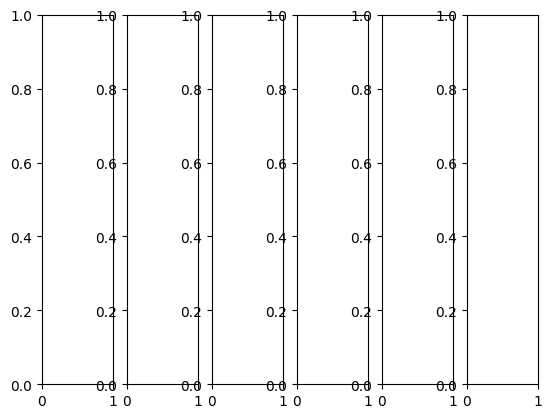

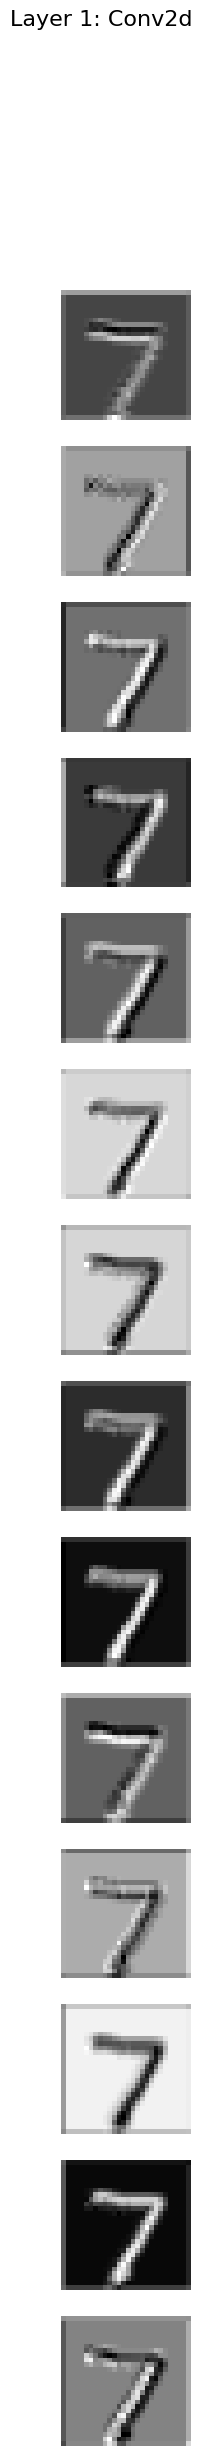

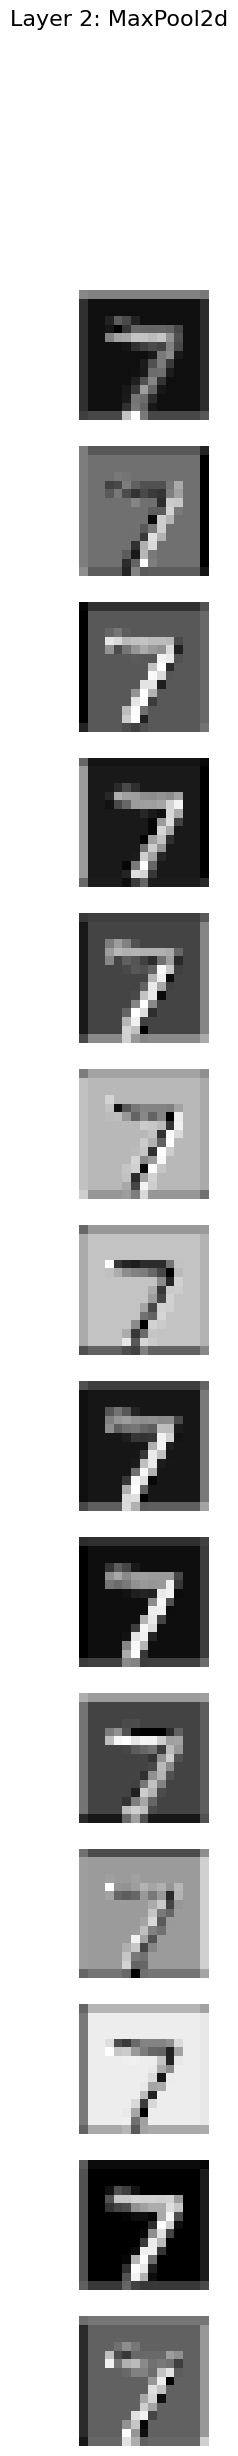

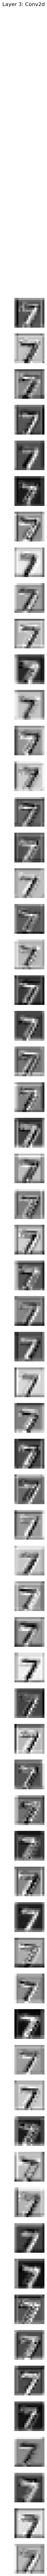

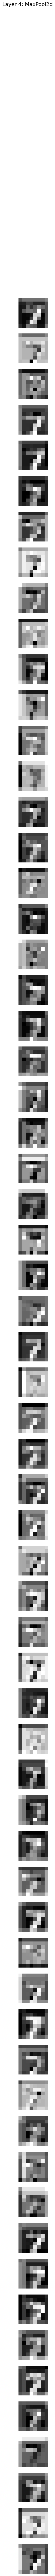

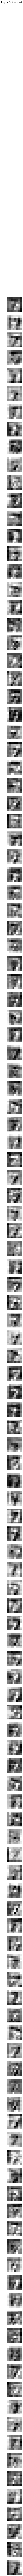

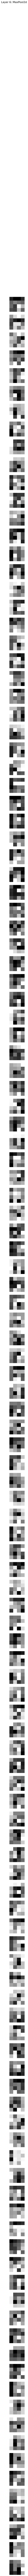

In [ ]:

plot_mapped_features_all_channels(optimized_model, example_image, layers)

As the layers increase, the filters become less readable to the human eye and more readable to a machine. However, in layer 1 we see many different types of channeles that the human eye can distinguish. For example, in different channels we may see different edges "hilighted". It is also clear that some images have the colored inverted and there are several with blurring (for example the 6th and 7th channels in layer one).

**6. Visualizing and interpreting filters**
1. Use the function `plot_filters` to view the trained filters of the first convolutional layer.
2. Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

In [ ]:
# Function to visualize the filters of a given convolutional layer
def plot_filters(layer, n_filters=6):
    '''Example usage:

    >>> layer = model.conv1
    >>> plot_filters(layer, n_filters=6)

    '''
    # Clone the weights of the convolutional layer to avoid modifying the original weights
    filters = layer.weight.data.clone()
    # Normalize the filter values to the range [0, 1] for better visualization
    filters = filters - filters.min()
    filters = filters / filters.max()
    # Select the first n_filters to visualize
    filters = filters[:n_filters]
    # Create a subplot with 1 row and n_filters columns
    fig, axes = plt.subplots(1, n_filters)
    # Iterate over the selected filters
    for i, filter in enumerate(filters):
      # ADDED: if statement to handle grayscale filters, such as the filters that we are using
        if filter.shape[0] == 1:  # Handle grayscale filters
            filter = filter.squeeze(0)
            axes[i].imshow(filter, cmap='gray')
        else:
            # Transpose the filter dimensions to (height, width, channels) for visualization
            axes[i].imshow(np.transpose(filter, (1, 2, 0)))
        # Turn off the axis for a cleaner look
        axes[i].axis('off')
    # Display the filters
    plt.show()

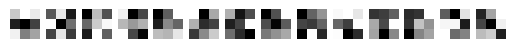

In [ ]:
layer = optimized_model.conv1
plot_filters(layer, n_filters=14)

In the above image, dark colors indicate higher values whereas light colors indicate smaller values. Lots of these filters are harder to interpret than the ones that we saw in lecture! However, we can see that the first filter looks like some horizontal blur and the last filter looks like a diagonal blur. Additionally, the second filter bears some resembalnce to the sharpening filter that we saw in lecture, however the dark and light pixels around the edges are swapped.

**7. Comparison to logistic regression**
1. Construct and run a pipeline for multiclass logistic regression of the MNIST dataset using sklearn.
2. Comment on how the training time and test accuracy of logistic regression compare to the CNN.
3. Now run multiclass logistic regression on the MNIST data set using one of the hidden states of the CNN (i.e., $\vec{x}^{(2)}$, $\vec{x}^{(3)}$, ..., $\vec{x}^{(7)}$) as inputs. Which set of inputs yields the best classification results?

In [8]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
# Flatten  images and convert to numpy arrays
X_train = train_set.dataset.data.numpy().reshape(-1, 28*28)
y_train = train_set.dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28)
y_test = test_dataset.targets.numpy()

# Use only the indices from the train_set to get the correct subset
train_indices = train_set.indices
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)

# Measure training time
start_time = time.time()
log_reg.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict and calculate accuracy
y_pred = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Training Time: {training_time:.4f} seconds")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")


Logistic Regression Training Time: 178.2334 seconds
Logistic Regression Test Accuracy: 0.9187


While the logistic regression model takes much less time to train than the CNN, it is also less accurate by a significant margin. Thus, If one is able to use a CNN and has the computing power available to train one, it will ultimately yield more accurate results.

Our pipeline for extracting features is shown below. Unfortunately this took A LOT of RAM, and we were not able to successfully run it (at least the second code block, wehre we train on the features extracted in the first code block) without the system crashing! However, we would expect the later layers to have higher accuracy since that is where the input is the most "transformed" to something small and unique that a machine can easily interpret.

In [12]:
def extract_features(model, data_loader, layer_num):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []

    # Create a list of layers in the model in order
    layers = [
        model.conv1,
        model.pool,
        model.conv2,
        model.pool,
        model.conv3,
        model.pool_no_padding,
        model.fc1
    ]

    with torch.no_grad():
        for images, lbls in data_loader:
            x = images.to(next(model.parameters()).device)

            # Pass the image through each layer until the desired layer
            for i, layer in enumerate(layers):
                x = layer(x)

                # Stop at the specified layer
                if i == (layer_num - 1):
                    break

            # Extract the feature map
            feature_maps = x.detach().cpu().numpy()
            feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)  # Flatten the feature maps
            features.append(feature_maps)
            labels.append(lbls.cpu().numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)

    return features, labels

# testing
features_train, labels_train = extract_features(optimized_model, train_loader, layer_num=2)
# features_test, labels_test = extract_features(optimized_model, test_loader, layer=2)


The below code block is the one that we had problems running, specifically we ran out of RAM and the system crashed causing us to have to retrain out entire `optimized_model`. We tried tweaking it a few times, but this proved to be challenging becuase eveyr time we had to retrain our original model, which was incredibly time consuming!

In [13]:
layer_accuracies = []

# go over every layer
for layer in range(1, 8):

    # the general idea is to irst extract features using the code above. Then, we can use this data to grain the multinomal logistic regression
    # on. This is the step that was particuarlly time consuming

    features_train, labels_train = extract_features(optimized_model, train_loader, layer_num=layer)
    features_test, labels_test = extract_features(optimized_model, test_loader, layer_num=layer)

    # Standardize the features
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)

    # Train logistic regression on the extracted features
    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
    log_reg.fit(features_train, labels_train)   # this is the time consuming line!!!

    # Predict and calculate accuracy
    y_pred = log_reg.predict(features_test)
    test_accuracy = accuracy_score(labels_test, y_pred)

    layer_accuracies.append((layer, test_accuracy))
    print(f"Layer {layer} - Test Accuracy: {test_accuracy:.4f}")


KeyboardInterrupt: 